# 5. Nonlinear Differential Equations 

In [1]:
import numpy as np

from scipy.linalg import solve

import matplotlib.pyplot as plt

In [2]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    I  = np.eye(N)
    Ic = np.ones((N, N)) - I
    
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    
    if N % 2 == 0:
        center = - (N**2 + 2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + I)**2 + center * I
    else:
        center = (1 - N**2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.sin(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / (np.sin(0.5 * ((row - col) * h)) * np.tan(0.5 * ((row - col) * h)) + I) + center * I
    return x, D1, D2

def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x  = np.cos(np.pi * row / N)
    c  = ((1 + (col % N == 0)) * (-1) ** col).T
    X  = np.ones(N + 1) * x
    dX = X - X.T
    D  = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

## 5.1 Nonlinear Ordinary Differential Equation

In this case, we will take a very nice example from the excellent paper by Dias, Santos and Way:

> [**Numerical Methods for Finding Stationary Gravitational Solutions**](https://arxiv.org/abs/1510.02804)   
> Óscar J.C. Dias, Jorge E. Santos and Benson Way
> <br>**Class.Quant.Grav. 33 (2016) 13, 133001**<br>
> https://arxiv.org/abs/1510.02804<br>

The equations we want to solve are

$$ q''(x) - e^{q(x)/2} = 0\, , \quad q(-1) = 0\, , \quad q'(1) - e^{q(1)} + 1 = 0\, .$$

Linearizing the equations as $q(x) \to q_0(x) - \delta q(x)$, we get linear equations for $\delta q(x)$, sourced by $q_0(x)$

$$ \left[ \partial_x^2 - \frac12 e^{q_0(x)/2}\right] \, \delta q(x) = q_0''(x) - e^{q_0(x)/2}\, ,$$
$$ \delta q(-1) = q_0(-1)\, , \quad  \left[\partial_x - e^{q_0(1)} \right] \, \delta q(1) = q_0'(1) - e^{q_0(1)} + 1\, .$$

The solution of the nonlinear problem is iterative: We start with a reasonable guess for $q_0(x)$, and solve the linearized equations for $\delta q(x)$. We then do the replacement $q_0(x) \to q_0(x) - \delta q(x)$, and start over again. We can stop the process stops when the right hand side of the equation gets close enough to $0$, or when $\delta q(x)$ is small enough. In this case, we choose the second option.

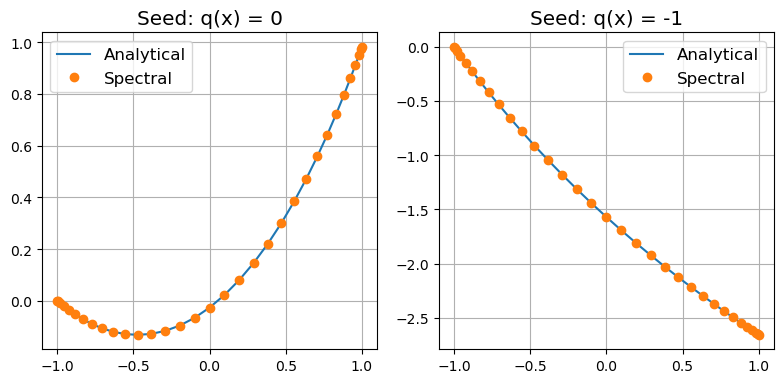

In [3]:
N = 32
x, D1, D2 = ChebyshevD(N)
I = np.eye(N+1)

params = [(0.483794, 0.472301), (0.110278, -11.2273)]  # Parameters of the analytic solutions
solutions = np.zeros((N + 1, 2))

for sol in range(2):
    q = 0 * x - sol
    dq_max = 100
    while dq_max > 1e-12:
    
        # Linearized differential equation
        A = D2 - np.diag(0.5 * np.exp(0.5 * q[:, 0]))
        b = D2 @ q - np.exp(0.5 * q)
        
        # Boundary conditions at x = -1
        A[-1, :] = I[-1, :]
        b[-1, :] = q[-1, :]
        
        # Boundary conditions at x = +1
        A[0, :] = (D1 - np.diag(np.exp(q[:, 0])))[0, :]
        b[0, :] = (D1 @ q - np.exp(q) + 1)[0, :]
        
        dq = solve(A, b)
        q -= dq
        
        dq_max = np.sum(dq**2)
        
    solutions[:, [sol]] = q

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (8, 4));
plt.rc('font', size = 12)

for i in range(2):
    A, B = params[i]
    ax[i].plot(x, 4 * np.log(2 * A / np.cos(A * (x + B) ) ), label = 'Analytical')
    ax[i].plot(x, solutions[:, i], 'o', label = 'Spectral')
    ax[i].set_title(f'Seed: q(x) = {-i}')
    ax[i].legend()
    ax[i].grid()

plt.tight_layout()
################################################################################

## 5.2 Nonlinear Partial Differential Equation

This example comes from one of my own publications:

> [**Lattice black branes at large $D$**](https://arxiv.org/abs/2201.11687)   
> David Licht, Raimon Luna and Ryotaku Suzuki
> <br>**JHEP 04 (2022) 063, JHEP 04 (2022) 063**<br>
> https://arxiv.org/abs/2201.11687<br>

In this case, we will solve a 2D nonlinear partial differential equation

$$ \partial^2 R + \frac12 (\partial R)^2 + R = 0\, $$

on a lattice defined by the periodic coordinates

$$ u/k = x\, \sqrt{1 - \gamma^2} - \gamma\,  y \, , \quad v / k = y\, ,$$
$$ (u,v) \sim  (u,v) + 2\pi(n_u, n_v)\, , \quad (n_u, n_v) \in \mathbb{Z}^2\, . $$

In these coordinates, the PDE equation becomes

$$F = R + \frac12 k^2 \left[ (\partial R)^2 + 2 \partial^2 R - 2 \gamma \left(  \partial_u R \, \partial_v R + 2 \partial_u \partial_v R\right) \right] = 0\,.$$

Taking linear perturbations of the form $R \to R_0 - \delta R$ and discretizing, we get the equation $J \cdot \delta R = F$, with the "Jacobian" matrix $J$  defined as

$$ J = I + k^2 \left[ D_u^2 + D_v^2 + \partial_u R \cdot D_u + \partial_v R \cdot D_v - \gamma \left(\partial_u R \cdot D_v + \partial_v R \cdot D_u + 2 D_u \cdot D_v \right)\right] \, .$$

The solution is then found by iteratively solving the linearized problem for the correction $\delta R$, until the equation is satisfied to its desired accuracy. In this case, periodic boundary conditions are automatically imposed by the Fourier grid.

In [4]:
N = 20
x, D1, D2 = FourierD(N)

u_sq = x @ np.ones((1, N))
v_sq = np.ones((N, 1)) @ x.T
u = u_sq.reshape(N**2, 1)
v = v_sq.reshape(N**2, 1)

Du = np.kron(D1, np.eye(N))
Dv = np.kron(np.eye(N), D1)
I  = np.eye(N**2)

def relax(R_guess, gamma, k):
    
    R = R_guess.copy()
    dR_max = 100
    
    while dR_max > 1e-10:
        Ru  = Du @ R;  Ruu = Du @ Ru
        Rv  = Dv @ R;  Rvv = Dv @ Rv
        Ruv = Dv @ Ru; Rud = np.diag(Ru[:,0]); Rvd = np.diag(Rv[:,0])

        rhs = R + 0.5 * k**2 * (Ru**2 + Rv**2 + 2 * Ruu + 2 * Rvv - 2 * gamma * Ru * Rv - 4 * gamma * Ruv)
        J   = I + k**2 * (Du @ Du + Dv @ Dv + Rud @ Du + Rvd @ Dv - gamma * (2 *  Du @ Dv + Rud @ Dv + Rvd @ Du))

        dR = solve(J, rhs)
        R -= dR
        
        dR_max = np.max(np.abs(rhs))
        
    return R

We define the function `plot_xy(R, gamma, k, fig, ax)` to convert the solutions in coordinates $(u, v)$ back to coordinates $(x,y)$ and plot them as a color map.

In [5]:
def lattice(x, i, j):
    x_l = np.vstack([x   + 2*i*n*np.pi for n in range(-3,3)])
    x_l = np.hstack([x_l + 2*j*n*np.pi for n in range(-3,3)])
    return x_l

def plot_xy(R, gamma, k, fig, ax):
    R_sq   = R.reshape(N, N)
    u_sq_l = lattice(u_sq, 1, 0)
    v_sq_l = lattice(v_sq, 0, 1)
    R_sq_l = lattice(R_sq, 0, 0)

    x = (u_sq_l + gamma * v_sq_l) / (k * np.sqrt(1 - gamma**2))
    y = v_sq_l / k
    
    cf = ax.contourf(x, y, np.exp(R_sq_l))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    fig.colorbar(cf, ax = ax)

The cells below explore different branches of solutions for different scales $k$ and lattice angles $\gamma$. Try some more!

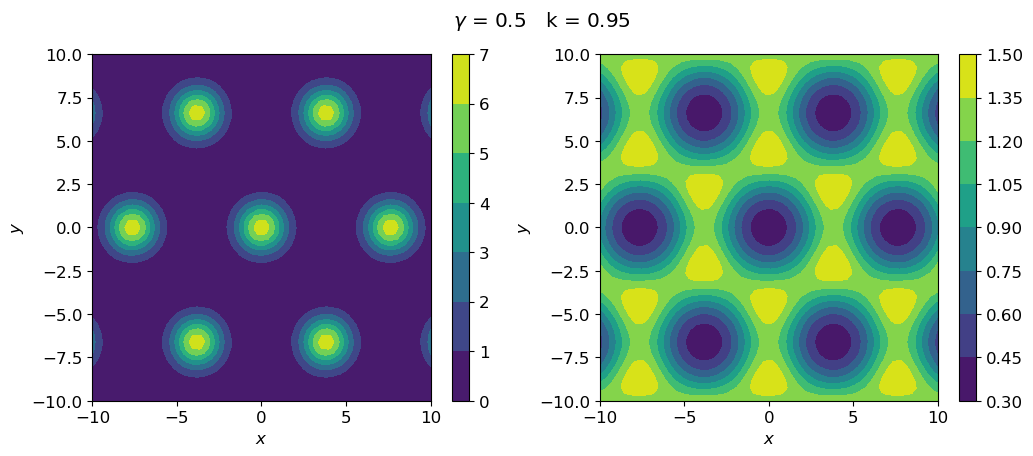

In [6]:
gamma = 0.5
k = 0.95

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
plt.rc('font', size = 12)

R_hex = -1 * (np.cos(u) + np.cos(v))
R_tri =  3 * (np.cos(u) + np.cos(v))
R_hex = relax(R_hex, gamma, k)
R_tri = relax(R_tri, gamma, k)

fig.suptitle(r'$\gamma$' + f' = {gamma}   k = {k}')

plot_xy(R_tri, gamma, k, fig, ax[0])
plot_xy(R_hex, gamma, k, fig, ax[1])

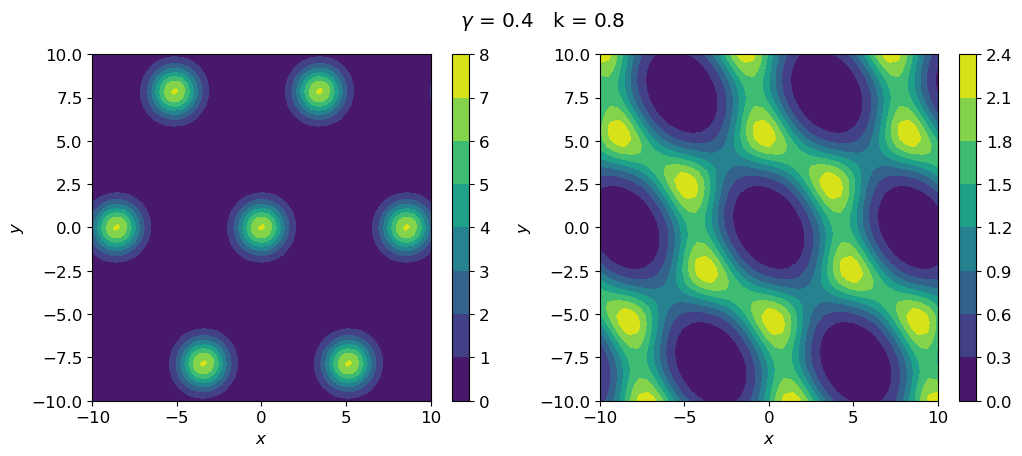

In [7]:
gamma = 0.4
k = 0.8

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
plt.rc('font', size = 12)

R_hex = -1 * (np.cos(u) + np.cos(v))
R_tri =  3 * (np.cos(u) + np.cos(v))
R_hex = relax(R_hex, gamma, k)
R_tri = relax(R_tri, gamma, k)

fig.suptitle(r'$\gamma$' + f' = {gamma}   k = {k}')

plot_xy(R_tri, gamma, k, fig, ax[0])
plot_xy(R_hex, gamma, k, fig, ax[1])